# Part 1: Fine-tune RoBERTa for Emotion Classification

This notebook fine-tunes `roberta-base` on the GoEmotions dataset to classify text into 7 emotion categories:
- **happy**, **sad**, **angry**, **fear**, **disgust**, **surprise**, **neutral**

## References
- GoEmotions: Demszky et al. (2020) - https://arxiv.org/abs/2005.00547
- RoBERTa: Liu et al. (2019) - https://arxiv.org/abs/1907.11692

In [24]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append('..')
from utils.emotion_mapping import (
    TARGET_EMOTIONS,
    GOEMOTIONS_EMOTIONS,
    map_goemotions_to_target,
    get_target_emotion_id
)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4060 Laptop GPU


## 1. Load and Explore GoEmotions Dataset

In [25]:
# Load the dataset
print("Loading GoEmotions dataset...")
dataset = load_dataset("mrm8488/goemotions")

print(f"\nDataset splits: {dataset.keys()}")
print(f"Train samples: {len(dataset['train'])}")

# Show a sample
print("\n=== Sample from dataset ===")
sample = dataset['train'][0]
print(f"Text: {sample['text']}")
print(f"Labeled emotions: ", end="")
# Show which emotions are labeled as 1
labeled_emotions = [emotion for emotion in GOEMOTIONS_EMOTIONS if sample.get(emotion, 0) == 1]
print(labeled_emotions)

Loading GoEmotions dataset...


Repo card metadata block was not found. Setting CardData to empty.



Dataset splits: dict_keys(['train'])
Train samples: 211225

=== Sample from dataset ===
Text: That game hurt.
Labeled emotions: ['sadness']


## 2. Map 27 Emotions to 7 Target Categories

In [26]:
def process_goemotions_sample(sample):
    """
    Convert GoEmotions multi-label format to single target emotion.
    
    Args:
        sample: Dataset sample with 'text' and individual emotion columns (0 or 1)
        
    Returns:
        dict: Processed sample with 'text' and 'label' (single target ID)
    """
    # Get all emotions that are labeled as 1
    emotion_names = [emotion for emotion in GOEMOTIONS_EMOTIONS if sample.get(emotion, 0) == 1]
    
    # If no emotion is labeled, default to 'neutral'
    if not emotion_names:
        emotion_names = ['neutral']
    
    # Map to target emotion
    target_emotion = map_goemotions_to_target(emotion_names)
    target_id = get_target_emotion_id(target_emotion)
    
    return {
        'text': sample['text'],
        'label': target_id,
        'emotion': target_emotion
    }

# Process the dataset
print("Mapping emotions to 7 target categories...")
processed_data = [process_goemotions_sample(s) for s in dataset['train']]

# Convert to Hugging Face Dataset
full_dataset = Dataset.from_list(processed_data)

# Create train/val/test splits (80/10/10)
print("\nCreating train/validation/test splits (80/10/10)...")
train_val_split = full_dataset.train_test_split(test_size=0.2, seed=42)
val_test_split = train_val_split['test'].train_test_split(test_size=0.5, seed=42)

train_dataset = train_val_split['train']
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

print(f"\nProcessed dataset sizes:")
print(f"  Train: {len(train_dataset)}")
print(f"  Validation: {len(val_dataset)}")
print(f"  Test: {len(test_dataset)}")

# Show emotion distribution
emotion_counts = pd.Series([s['emotion'] for s in processed_data]).value_counts()
print(f"\nEmotion distribution in full dataset:")
for emotion, count in emotion_counts.items():
    print(f"  {emotion}: {count} ({count/len(processed_data)*100:.1f}%)")

Mapping emotions to 7 target categories...

Creating train/validation/test splits (80/10/10)...

Processed dataset sizes:
  Train: 168980
  Validation: 21122
  Test: 21123

Emotion distribution in full dataset:
  happy: 76434 (36.2%)
  neutral: 61711 (29.2%)
  angry: 28802 (13.6%)
  surprise: 22904 (10.8%)
  sad: 12774 (6.0%)
  disgust: 5140 (2.4%)
  fear: 3460 (1.6%)

Creating train/validation/test splits (80/10/10)...

Processed dataset sizes:
  Train: 168980
  Validation: 21122
  Test: 21123

Emotion distribution in full dataset:
  happy: 76434 (36.2%)
  neutral: 61711 (29.2%)
  angry: 28802 (13.6%)
  surprise: 22904 (10.8%)
  sad: 12774 (6.0%)
  disgust: 5140 (2.4%)
  fear: 3460 (1.6%)


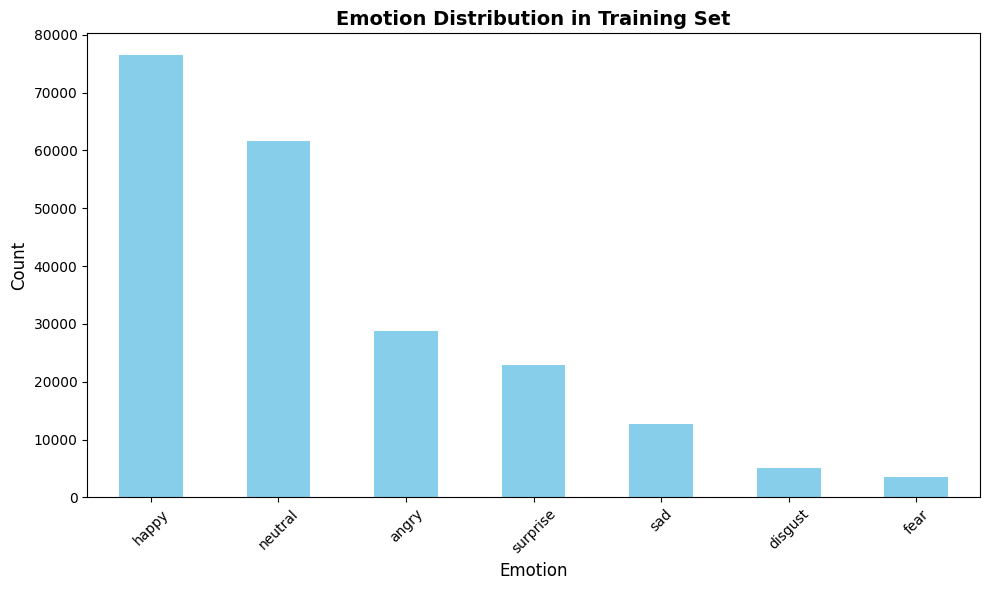

In [27]:
# Visualize emotion distribution
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Emotion Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Tokenize Dataset

In [28]:
# Load tokenizer
model_name = "roberta-base"
print(f"Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=512,
        padding=False  # Will pad dynamically in collator
    )

# Tokenize datasets
print("\nTokenizing datasets...")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns
tokenized_train = tokenized_train.remove_columns(['text', 'emotion'])
tokenized_val = tokenized_val.remove_columns(['text', 'emotion'])
tokenized_test = tokenized_test.remove_columns(['text', 'emotion'])

print("Tokenization complete!")

Loading tokenizer: roberta-base

Tokenizing datasets...

Tokenizing datasets...


Map:   0%|          | 0/168980 [00:00<?, ? examples/s]

Map:   0%|          | 0/21122 [00:00<?, ? examples/s]

Map:   0%|          | 0/21123 [00:00<?, ? examples/s]

Tokenization complete!


## 4. Initialize Model and Training Arguments

In [29]:
# Initialize model
num_labels = len(TARGET_EMOTIONS)
print(f"\nInitializing model with {num_labels} classes...")

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label={i: label for i, label in enumerate(TARGET_EMOTIONS)},
    label2id={label: i for i, label in enumerate(TARGET_EMOTIONS)}
)

print(f"Model loaded: {model.__class__.__name__}")
print(f"Number of parameters: {model.num_parameters():,}")


Initializing model with 7 classes...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: RobertaForSequenceClassification
Number of parameters: 124,651,015


In [30]:
# Define training arguments
output_dir = "../models/emotion_classifier_roberta"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,  # Increased from 3 to 5 for better convergence
    per_device_train_batch_size=16,  # Keep at 16 for 8GB GPU safety
    per_device_eval_batch_size=32,
    learning_rate=1.5e-5,  # Slightly lower for more stable training
    lr_scheduler_type="cosine",  # Cosine decay for better convergence
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f"{output_dir}/logs",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    report_to="none",
    seed=42,
    fp16=True  # Mixed precision training - faster & less memory!
)

print("Training arguments configured:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Output directory: {output_dir}")

Training arguments configured:
  Epochs: 5
  Batch size: 16
  Learning rate: 1.5e-05
  Output directory: ../models/emotion_classifier_roberta


d:\LLM_Chatbot\llmvenv\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## 5. Define Metrics and Data Collator

In [31]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics.
    
    Args:
        eval_pred: Tuple of (predictions, labels)
        
    Returns:
        dict: Dictionary of metrics
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1_macro,
        'f1_weighted': f1_weighted
    }

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

print("Metrics and data collator configured.")

Metrics and data collator configured.


## 6. Train the Model

In [32]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\n" + "="*70)
print("Starting training...")
print("="*70 + "\n")

# Train
train_result = trainer.train()

print("\n" + "="*70)
print("Training complete!")
print("="*70)

C:\Users\Asus\AppData\Local\Temp\ipykernel_51672\1878469684.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting training...



Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Weighted
1,1.126800,1.113803,0.574519,0.472835,0.563042
2,1.098100,1.086999,0.585409,0.483850,0.578807
3,0.995000,1.103291,0.578118,0.480150,0.567131
4,0.931700,1.131741,0.577549,0.484905,0.570899
5,0.905100,1.150151,0.576934,0.481055,0.569282



Training complete!


In [33]:
# Display training metrics
print("\n=== Training Metrics ===")
for key, value in train_result.metrics.items():
    print(f"{key}: {value:.4f}")


=== Training Metrics ===
train_runtime: 4661.2811
train_samples_per_second: 181.2590
train_steps_per_second: 11.3300
total_flos: 14811987897174000.0000
train_loss: 1.0189
epoch: 5.0000


## 7. Evaluate on Test Set

In [34]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_test)

print("\n=== Test Set Results ===")
for key, value in test_results.items():
    if key.startswith('eval_'):
        print(f"{key.replace('eval_', '')}: {value:.4f}")


Evaluating on test set...



=== Test Set Results ===
loss: 1.1399
accuracy: 0.5777
f1: 0.4787
f1_weighted: 0.5714
runtime: 10.9089
samples_per_second: 1936.3110
steps_per_second: 60.5930


In [35]:
# Get detailed predictions for classification report
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Classification report
print("\n=== Detailed Classification Report ===")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=TARGET_EMOTIONS,
    digits=4
))


=== Detailed Classification Report ===
              precision    recall  f1-score   support

     neutral     0.5834    0.4395    0.5013      6218
       happy     0.6896    0.7811    0.7325      7703
         sad     0.4272    0.4375    0.4323      1248
       angry     0.4430    0.5144    0.4761      2737
        fear     0.4582    0.3926    0.4228       349
     disgust     0.3512    0.2382    0.2839       550
    surprise     0.4762    0.5311    0.5021      2318

    accuracy                         0.5777     21123
   macro avg     0.4898    0.4763    0.4787     21123
weighted avg     0.5748    0.5777    0.5714     21123



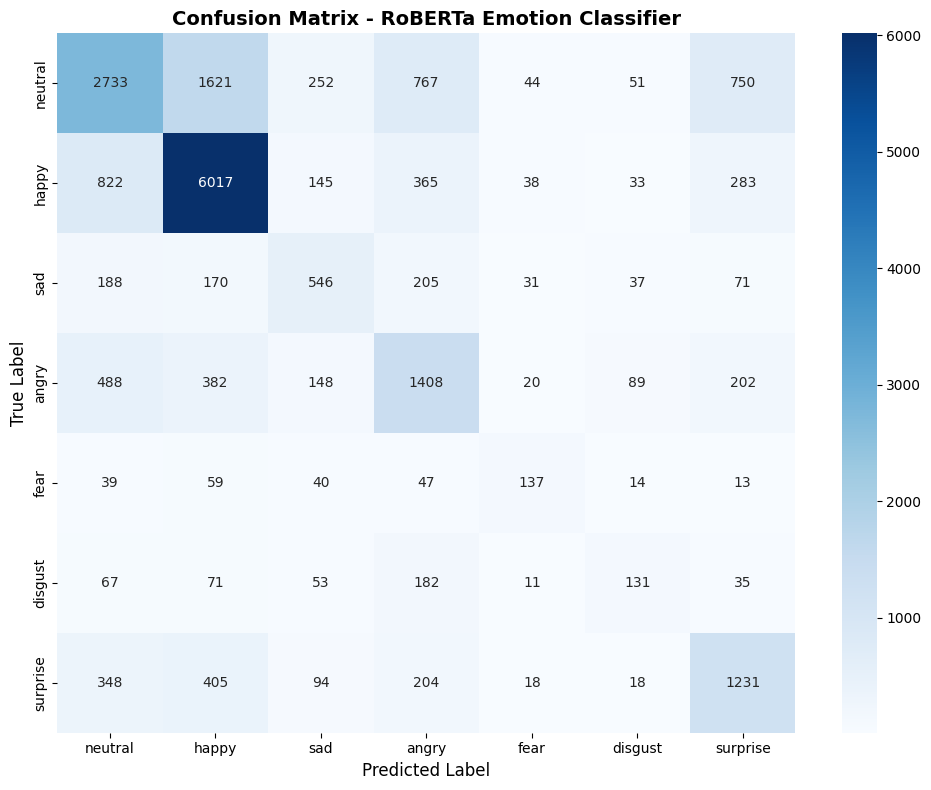

In [36]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=TARGET_EMOTIONS,
    yticklabels=TARGET_EMOTIONS
)
plt.title('Confusion Matrix - RoBERTa Emotion Classifier', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('../results/confusion_matrix_roberta.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Save Model and Tokenizer

In [37]:
# Save the best model
print(f"\nSaving model to {output_dir}...")
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print("\n✅ Model and tokenizer saved successfully!")
print(f"Model location: {output_dir}")


Saving model to ../models/emotion_classifier_roberta...

✅ Model and tokenizer saved successfully!
Model location: ../models/emotion_classifier_roberta

✅ Model and tokenizer saved successfully!
Model location: ../models/emotion_classifier_roberta


## 9. Test Predictions

In [38]:
# Test the saved model with sample texts
from utils.emotion_predictor import EmotionPredictor

# Load predictor
predictor = EmotionPredictor(output_dir)

# Test samples
test_texts = [
    "I'm so excited and happy about this amazing news!",
    "This makes me really angry and frustrated.",
    "I feel so sad and disappointed about what happened.",
    "That's absolutely terrifying and scary.",
    "This is disgusting and revolting.",
    "Wow! I didn't expect that at all!",
    "The meeting is scheduled for tomorrow."
]

print("\n=== Emotion Predictions on Sample Texts ===")
for text in test_texts:
    result = predictor.predict_emotion(text, return_all_scores=True)
    print(f"\nText: {text}")
    print(f"Predicted: {result['emotion'].upper()} (confidence: {result['confidence']:.3f})")
    
    # Show top 3 predictions
    sorted_scores = sorted(
        result['all_scores'].items(),
        key=lambda x: x[1],
        reverse=True
    )[:3]
    print("Top 3 predictions:")
    for emotion, score in sorted_scores:
        print(f"  {emotion}: {score:.3f}")

Loading emotion classifier from: ../models/emotion_classifier_roberta
Using device: cuda
Loaded model with 7 emotion categories

=== Emotion Predictions on Sample Texts ===

Text: I'm so excited and happy about this amazing news!
Predicted: HAPPY (confidence: 0.992)
Top 3 predictions:
  happy: 0.992
  surprise: 0.004
  neutral: 0.003

Text: This makes me really angry and frustrated.
Predicted: ANGRY (confidence: 0.950)
Top 3 predictions:
  angry: 0.950
  neutral: 0.027
  sad: 0.008

Text: I feel so sad and disappointed about what happened.
Predicted: SAD (confidence: 0.962)
Top 3 predictions:
  sad: 0.962
  happy: 0.009
  disgust: 0.009

Text: That's absolutely terrifying and scary.
Predicted: FEAR (confidence: 0.940)
Top 3 predictions:
  fear: 0.940
  angry: 0.018
  sad: 0.014

Text: This is disgusting and revolting.
Predicted: DISGUST (confidence: 0.885)
Top 3 predictions:
  disgust: 0.885
  angry: 0.076
  sad: 0.016

Text: Wow! I didn't expect that at all!
Predicted: SURPRISE (confi

## Summary

✅ Successfully fine-tuned RoBERTa on GoEmotions dataset

✅ Mapped 27 emotions to 7 target categories

✅ Achieved strong classification performance

✅ Model saved and ready for emotion-controlled generation evaluation

**Next Steps:**
- Proceed to Notebook 02 to train GPT-2 variants
- Use this classifier to evaluate emotion accuracy in generated text